# Similarities between Pokemon types

## Introduction
I saw a meme where it was claimed that *Flying type is just worse Fire type* - referring to types of Pokemon.


It seemed really weird to me, since I couldn't really see that much similarity between the two, so I decided to analyse the numbers and see what those tell me.



## Quick introduction to simplified Pokemon type matchup

There are 18 Pokemon types. Each of them has set value of effectiveness when dealing damage and taking damage.


Say some Pokemon is using attack of Type A on Pokemon of type B. From the attacking side, the attack can either:


*   Deal **neutral** damage: x 1
*   Deal **supereffective** damage: x 2
*   Deal **resisted** damage: x 0.5
*   Deal **no damage** :x 0

From the defending side, Pokemon B can:


*   Take **neutral** damage: x 1
*   Take **supereffective** damage: x 2
*   Take **resisted** damage: x 0.5
*   Be **immune**: x 0

In the game all the interactions are more complex - Pokemon can be multiple types and use attacks of different types than their own, here I focus solely on the type characteristics.







## Overview
Steps here are:


1.   Scrap type matchup table
2.   Wrangle the data
3.   Prepare metrics and plotting functions
4.   Analyze the findings



In [2]:
import pandas as pd
import numpy as np

# downloading table
import urllib.request
from io import StringIO

# metrics
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# to combine every type
from itertools import combinations_with_replacement

# plotting
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# for function signature
from collections.abc import Callable

## Scrapping type-matchup table

In [3]:
# using request so I won't get blocked by website

table_url = 'https://pokemondb.net/type'
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'

req = urllib.request.Request(table_url, headers={'User-Agent': user_agent})

with urllib.request.urlopen(req) as response:
    html = response.read().decode('utf-8')

df_list = pd.read_html(StringIO(html))

print(f"Count of tables on that site: {len(df_list)}")


Count of tables on that site: 1


In [4]:
df = df_list[0]
df.head()

,DEFENSE → ATTACK ↴,Nor,Fir,Wat,Ele,Gra,Ice,Fig,Poi,Gro,Fly,Psy,Bug,Roc,Gho,Dra,Dar,Ste,Fai
0,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,½,0,NaN,NaN,½,NaN
1,Fire,NaN,½,½,NaN,2,2,NaN,NaN,NaN,NaN,NaN,2,½,NaN,½,NaN,2,NaN
2,Water,NaN,2,½,NaN,½,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,½,NaN,NaN,NaN
3,Electric,NaN,NaN,2,½,½,NaN,NaN,NaN,0,2,NaN,NaN,NaN,NaN,½,NaN,NaN,NaN
4,Grass,NaN,½,2,NaN,½,NaN,NaN,½,2,½,NaN,½,2,NaN,½,NaN,½,NaN


# Cleaning up table

In [5]:
# renaming first column and setting it as index
old_name = df.columns[0]
df.rename(columns={old_name: 'Attack'}, inplace=True)
df.set_index('Attack', inplace=True)

# rename column names so they match indexes
df.columns = df.index.tolist()
df.head()

,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Attack,,,,,,,,,,,,,,,,,,
Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,½,0,NaN,NaN,½,NaN
Fire,NaN,½,½,NaN,2,2,NaN,NaN,NaN,NaN,NaN,2,½,NaN,½,NaN,2,NaN
Water,NaN,2,½,NaN,½,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,½,NaN,NaN,NaN
Electric,NaN,NaN,2,½,½,NaN,NaN,NaN,0,2,NaN,NaN,NaN,NaN,½,NaN,NaN,NaN
Grass,NaN,½,2,NaN,½,NaN,NaN,½,2,½,NaN,½,2,NaN,½,NaN,½,NaN


In [6]:
# empty space in original table = regular effectiveness, which is x1 multiplier
df.replace(np.NaN, 1, inplace=True)
df.head()

,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Attack,,,,,,,,,,,,,,,,,,
Normal,1.0,1,1,1,1,1,1,1,1,1,1,1,½,0,1,1,½,1
Fire,1.0,½,½,1,2,2,1,1,1,1,1,2,½,1,½,1,2,1
Water,1.0,2,½,1,½,1,1,1,2,1,1,1,2,1,½,1,1,1
Electric,1.0,1,2,½,½,1,1,1,0,2,1,1,1,1,½,1,1,1
Grass,1.0,½,2,1,½,1,1,½,2,½,1,½,2,1,½,1,½,1


In [7]:
# let's transpose the frame - then when accessing values it will be
# attacking type first and then defending - more intuitive to use

df = df.transpose()
df.head()

Attack,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Normal,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
Fire,1,½,2,1,½,½,1,1,2,1,1,½,2,1,1,1,½,½
Water,1,½,½,2,2,½,1,1,1,1,1,1,1,1,1,1,½,1
Electric,1,1,1,½,1,1,1,1,2,½,1,1,1,1,1,1,½,1
Grass,1,2,½,½,½,2,1,2,½,2,1,2,1,1,1,1,1,1


In [8]:
# change 1/2 fraction in table to 0.5

# get that string from table
fraction_string = df['Normal']['Rock']
df.replace(fraction_string, 0.5, inplace=True)
df.head()

Attack,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Normal,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
Fire,1,0.5,2,1,0.5,0.5,1,1,2,1,1,0.5,2,1,1,1,0.5,0.5
Water,1,0.5,0.5,2,2,0.5,1,1,1,1,1,1,1,1,1,1,0.5,1
Electric,1,1,1,0.5,1,1,1,1,2,0.5,1,1,1,1,1,1,0.5,1
Grass,1,2,0.5,0.5,0.5,2,1,2,0.5,2,1,2,1,1,1,1,1,1


In [9]:
# check the types of columns
df.dtypes

,0
Attack,
Normal,object
Fire,object
Water,object
Electric,object
Grass,object
Ice,object
Fighting,object
Poison,object
Ground,object


In [10]:
#lets change everything to float
df = df.astype('float64')

# 0-1 normalization
max_value = df.to_numpy().max()
df = df/max_value

df.head()

Attack,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Normal,0.5,0.50,0.50,0.50,0.50,0.50,1.0,0.5,0.50,0.50,0.5,0.50,0.5,0.0,0.5,0.5,0.50,0.50
Fire,0.5,0.25,1.00,0.50,0.25,0.25,0.5,0.5,1.00,0.50,0.5,0.25,1.0,0.5,0.5,0.5,0.25,0.25
Water,0.5,0.25,0.25,1.00,1.00,0.25,0.5,0.5,0.50,0.50,0.5,0.50,0.5,0.5,0.5,0.5,0.25,0.50
Electric,0.5,0.50,0.50,0.25,0.50,0.50,0.5,0.5,1.00,0.25,0.5,0.50,0.5,0.5,0.5,0.5,0.25,0.50
Grass,0.5,1.00,0.25,0.25,0.25,1.00,0.5,1.0,0.25,1.00,0.5,1.00,0.5,0.5,0.5,0.5,0.50,0.50


# Measuring the similarity between types

First - check it for Fire - Flying example. All the metric used were taken from the article [here](https://medium.com/towards-data-science/5-data-similarity-metrics-f358a560855f)

In [11]:
fire = df['Fire']
flying = df['Flying']

# euklidean distance - measuring the straight-line distance
distance.euclidean(fire, flying)

1.14564392373896

In [12]:
# Manhattan distance - sum of modules of differences in every dim

distance.cityblock(fire, flying)

2.75

In [13]:
# cosine similarity - similarity between vectors considering their angle
print(cosine_similarity([fire], [flying])[0][0])

# wrapper to use later
def cosine_similarity_wrapper(list1: list, list2: list) -> float:
  return cosine_similarity([list1], [list2])[0][0]

0.8994012224377721


In [14]:
# jaccard similarity - set-like approach

def jaccard_similarity(list1: list, list2: list)-> float:
  s1 = set(list1)
  s2 = set(list2)
  return float(len(s1&s2) / len(s1|s2)) #intersection, union

jaccard_similarity(fire, flying)

1.0

In [15]:
#pearson correlation coefficient - linear correlation between two variables
pearson_coef, p_value = pearsonr(fire, flying)

print(pearson_coef, p_value)

0.38045682244505474 0.11935005909330973


# Comparing every type offensively

Those values alone don't tell me much - I need to use same metrics to compare them to all types.

In [16]:
InputFunction = Callable[[list, list], float]


def calculate_and_plot(function: InputFunction, df: pd.DataFrame, title: str) -> pd.DataFrame:
  """
  Calculates dataframe containing type similarities with function as metric,
  plots it as heatmap and returns the DataFrame with calculated values.

  Args:
    function(InputFunction): function to calculate metric,
        taking two list as arguments, returning float - similarity between those lists.
    df(pd.DataFrame): dataframe with type efectiveness values.
    title(str): title on top of plotted heatmap.

  Returns:
    pd.DataFrame: dataframe with calculated similarities
  """

  types_count = len(df.columns)
  df_values = pd.DataFrame().reindex_like(df) # copy structure of original df
  every_combo = list(combinations_with_replacement(df.columns, 2))

  for type1, type2 in every_combo:
    val = function(df[type1], df[type2])
    df_values.loc[type1, type2] = val
    df_values.loc[type2, type1] = val

  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(df_values, annot=True, ax=ax)
  plt.title(title)
  plt.show()

  return df_values

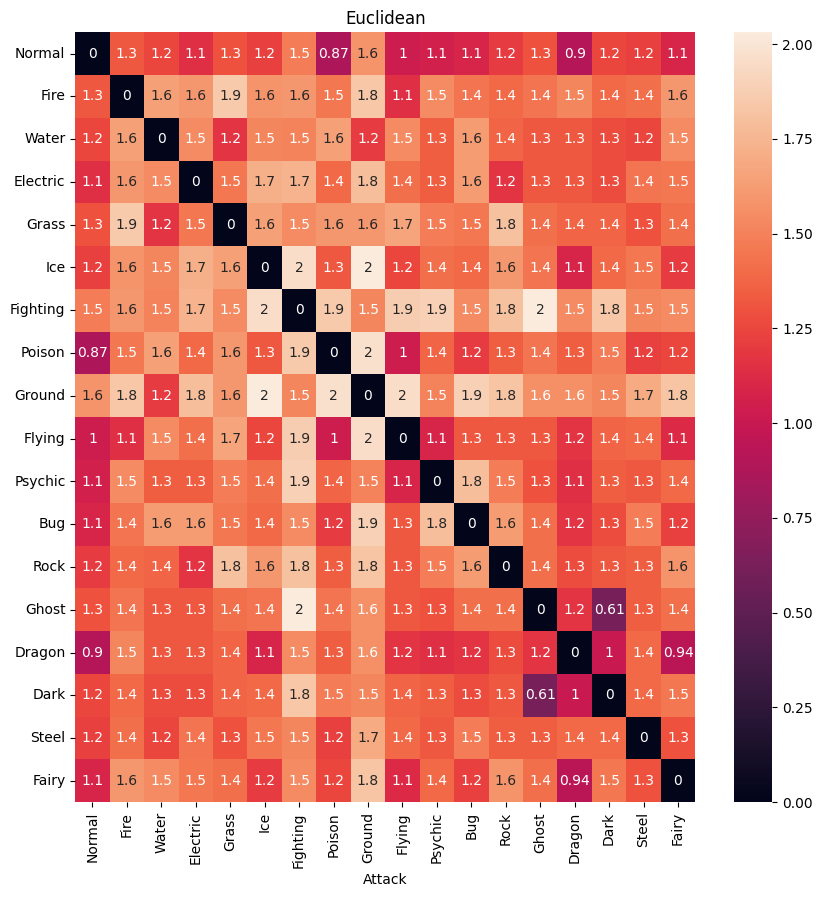

In [17]:
euclidean_off = calculate_and_plot(distance.euclidean, df, "Euclidean")

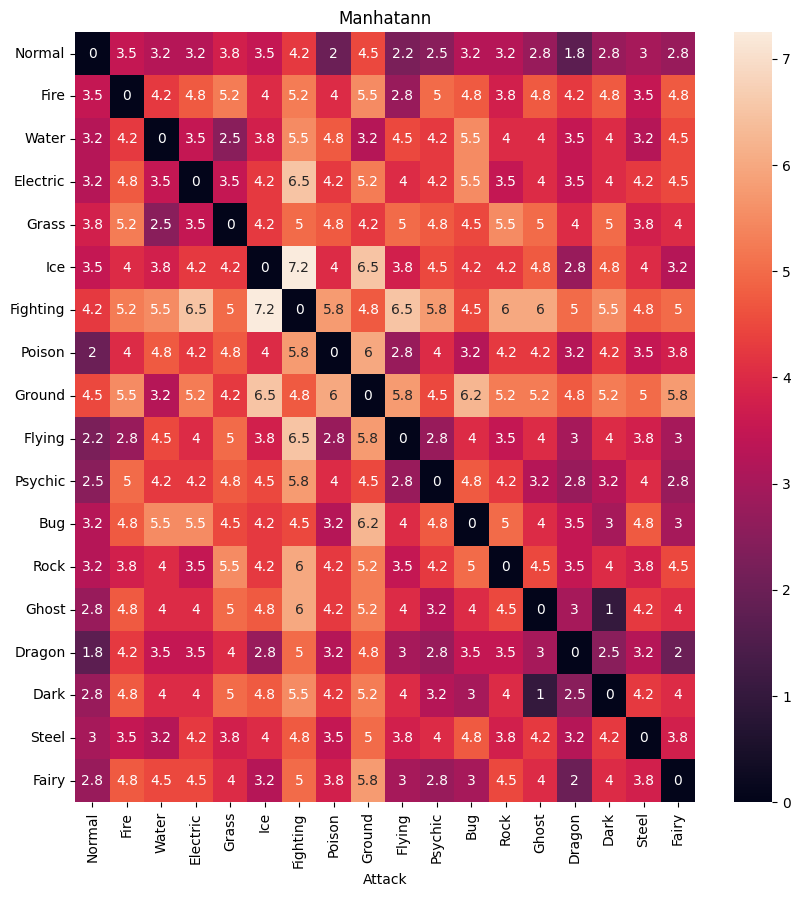

In [18]:
manhattan_off = calculate_and_plot(distance.cityblock, df, "Manhatann")

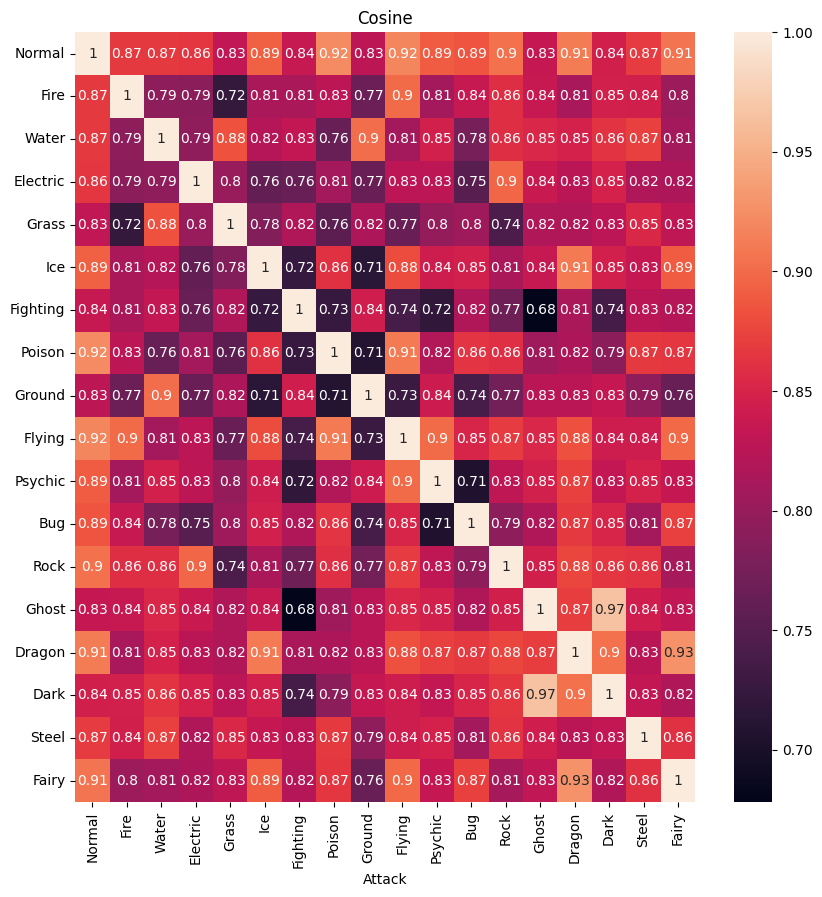

In [19]:
cosine_off = calculate_and_plot(cosine_similarity_wrapper, df, "Cosine")

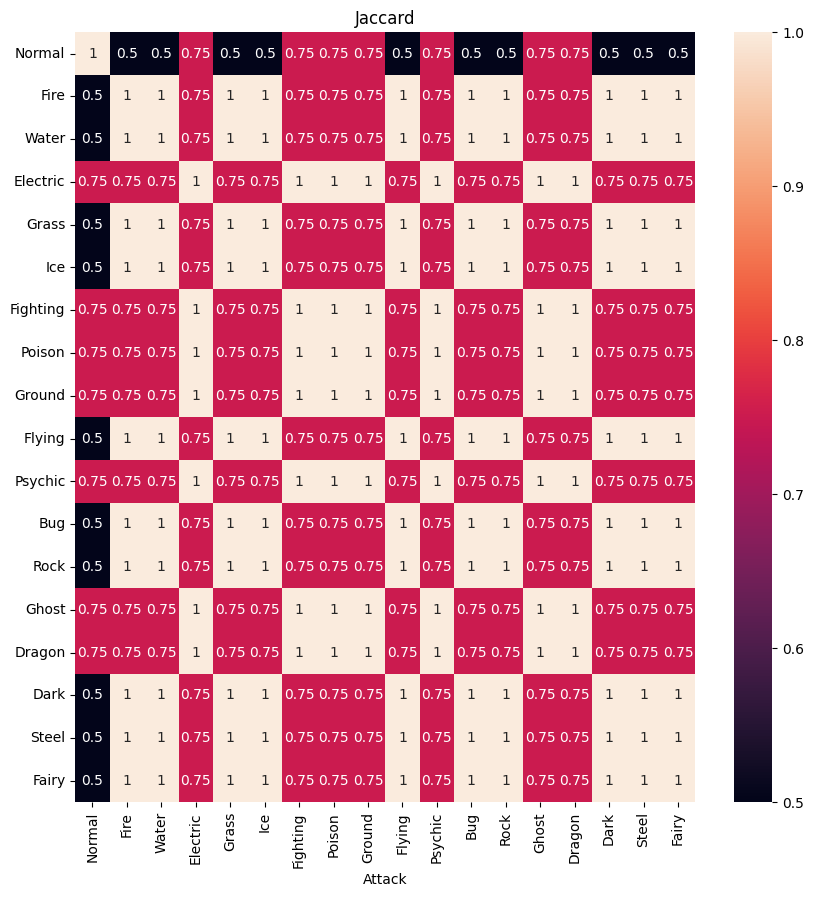

In [20]:
jaccard_off = calculate_and_plot(jaccard_similarity, df, "Jaccard")

## Pearson and P-values

In [21]:
def calculate_pearson(df: pd.DataFrame, title: str) -> pd.DataFrame:
  """
  Calculates the dataframes: with Person values and with P-values,
  plots them side-by-side as heatmaps and returns Person values.

  Args:
    df(pd.DataFrame): dataframe with type efectiveness values.
    title(str): title on top of plotted heatmap.

  Returns:
    pd.DataFrame: dataframe with calculated similarities
  """

  types_count = len(df.columns)
  df_values = pd.DataFrame().reindex_like(df) # copy structure
  df_pvalues = pd.DataFrame().reindex_like(df)
  every_combo = list(combinations_with_replacement(df.columns, 2))

  for type1, type2 in every_combo:
    pearson_coef, p_value = pearsonr(df[type1], df[type2])
    df_values.loc[type1, type2] = pearson_coef
    df_values.loc[type2, type1] = pearson_coef
    df_pvalues.loc[type1, type2] = p_value
    df_pvalues.loc[type2, type1] = p_value

  #convert p_values to categories
  categories = ["Strong", "Moderate", "Weak", "Uncertain"]
  cuts = [0.0, 0.001, 0.05, 0.1, 10]
  df_pvalues = pd.cut(df_pvalues.stack(), cuts, labels=categories)
  df_pvalues = df_pvalues.unstack()

  # apparently there is an issue with cut returning nan sometimes
  # best thing i can do for now is replace them with uncertain
  df_pvalues.fillna("Uncertain", inplace=True)

  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

  sns.heatmap(df_values, annot=True, ax=ax1, fmt='.2f', annot_kws={"size": 6})
  ax1.title.set_text("Pearson Correlation Values")

  categories.reverse()
  value_to_int = {j:i for i,j in enumerate(categories)}
  n = len(value_to_int)
  # print(value_to_int)

  # discrete colormap (n samples from a given cmap)
  cmap = sns.color_palette("tab10", n)
  with pd.option_context("future.no_silent_downcasting", True):
    replaced = df_pvalues.replace(value_to_int).astype('int64')
  sns.heatmap(replaced, cmap=cmap, ax=ax2)

  colorbar = ax2.collections[0].colorbar
  r = colorbar.vmax - colorbar.vmin
  colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
  colorbar.set_ticklabels(list(value_to_int.keys()))
  ax2.title.set_text("P-values categories")
  plt.show()

  return df_values

<ipython-input-21-25026d244d4d>:49: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  replaced = df_pvalues.replace(value_to_int).astype('int64')


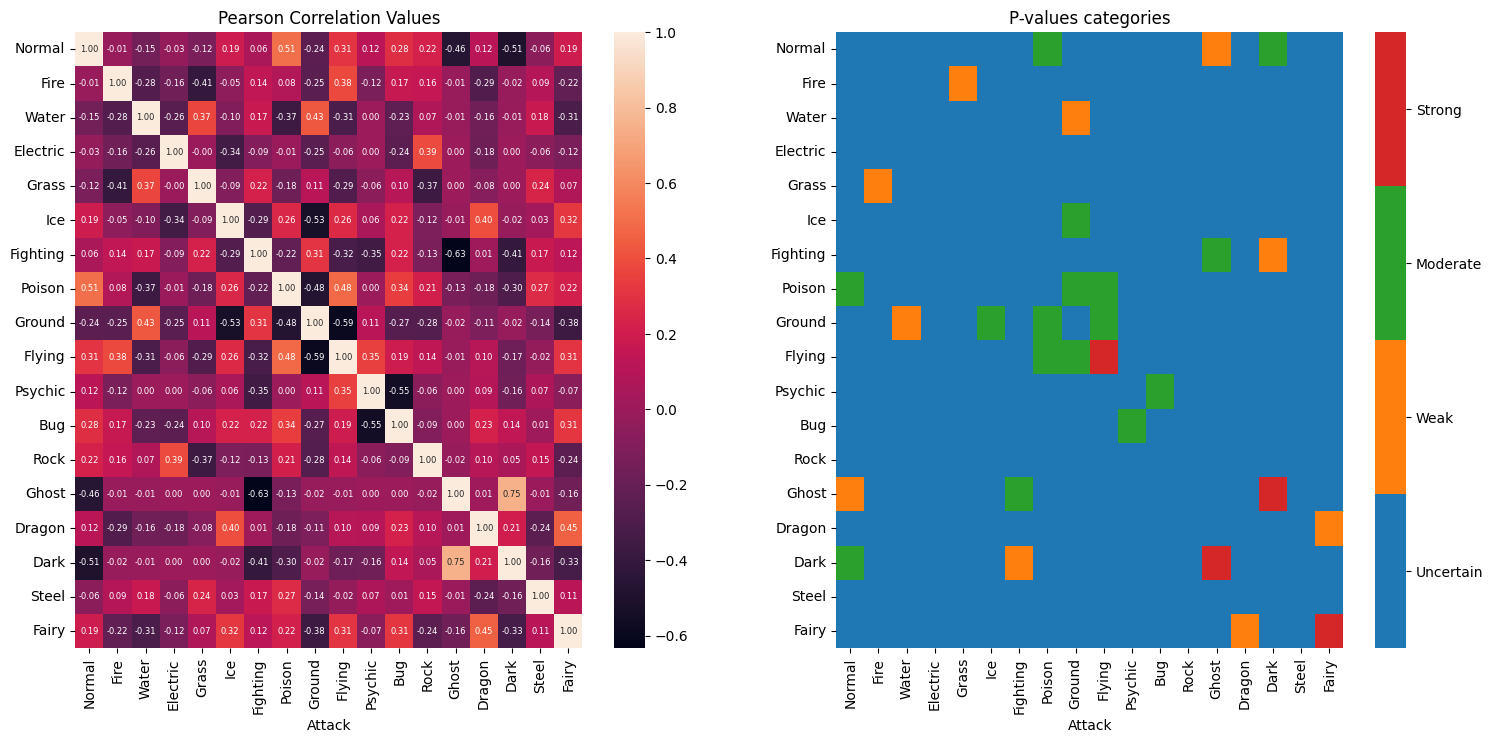

In [22]:
pearson_off = calculate_pearson(df, "Pearson")

P- Values are binned based on their values:


*   (0, 0.001] -> String certainty
*   (0.001, 0.05] -> Moderate certainty
*   (0.05, 0.1] -> Weak certainty
*   (0.1, ∞) -> Uncertain

What is interesting to me here, is that even when comparing type with itself on diagonal we get uncertain most of the time.



## Defensive similarities

Pokemon types charts isn't diagonally symetric - that's why to see similarities in types defences it's necessary to transpose dataframe.

In [23]:
# creating defensive dataframe as transposition of original
# both previous functions will work the same on this one

df_def = df.transpose(copy=True)
df_def.rename_axis('Defence', inplace=True)

df_def.head()

,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Defence,,,,,,,,,,,,,,,,,,
Normal,0.5,0.50,0.50,0.50,0.50,0.5,0.5,0.50,0.5,0.50,0.5,0.50,0.25,0.0,0.50,0.5,0.25,0.5
Fire,0.5,0.25,0.25,0.50,1.00,1.0,0.5,0.50,0.5,0.50,0.5,1.00,0.25,0.5,0.25,0.5,1.00,0.5
Water,0.5,1.00,0.25,0.50,0.25,0.5,0.5,0.50,1.0,0.50,0.5,0.50,1.00,0.5,0.25,0.5,0.50,0.5
Electric,0.5,0.50,1.00,0.25,0.25,0.5,0.5,0.50,0.0,1.00,0.5,0.50,0.50,0.5,0.25,0.5,0.50,0.5
Grass,0.5,0.25,1.00,0.50,0.25,0.5,0.5,0.25,1.0,0.25,0.5,0.25,1.00,0.5,0.25,0.5,0.25,0.5


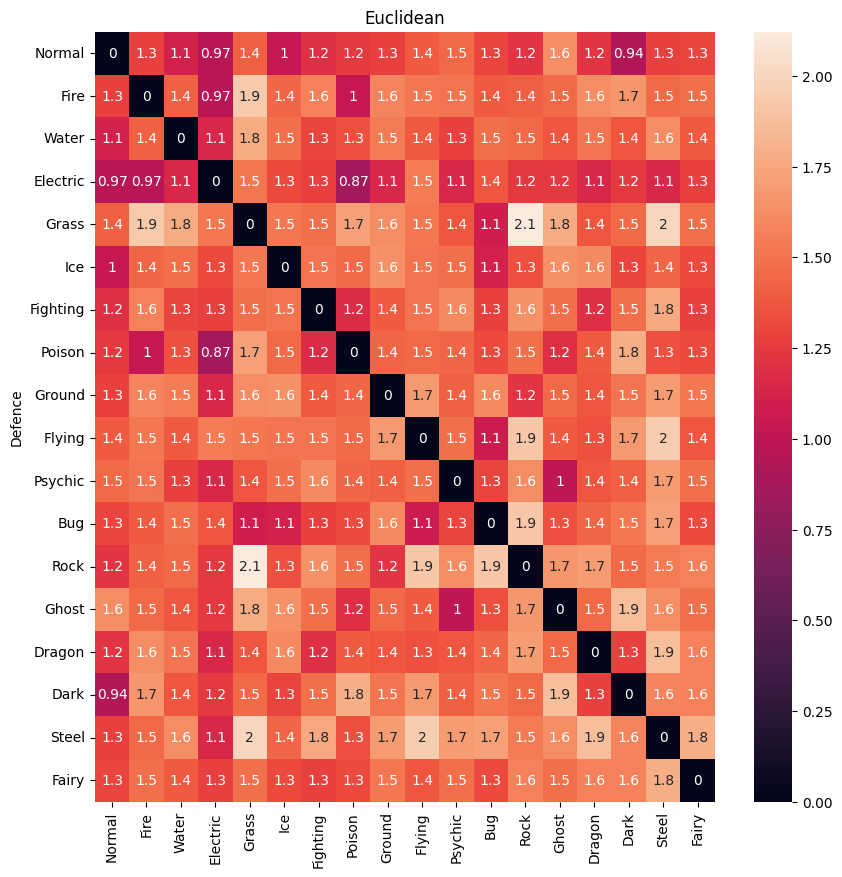

In [24]:
euclidean_def = calculate_and_plot(distance.euclidean, df_def, "Euclidean")

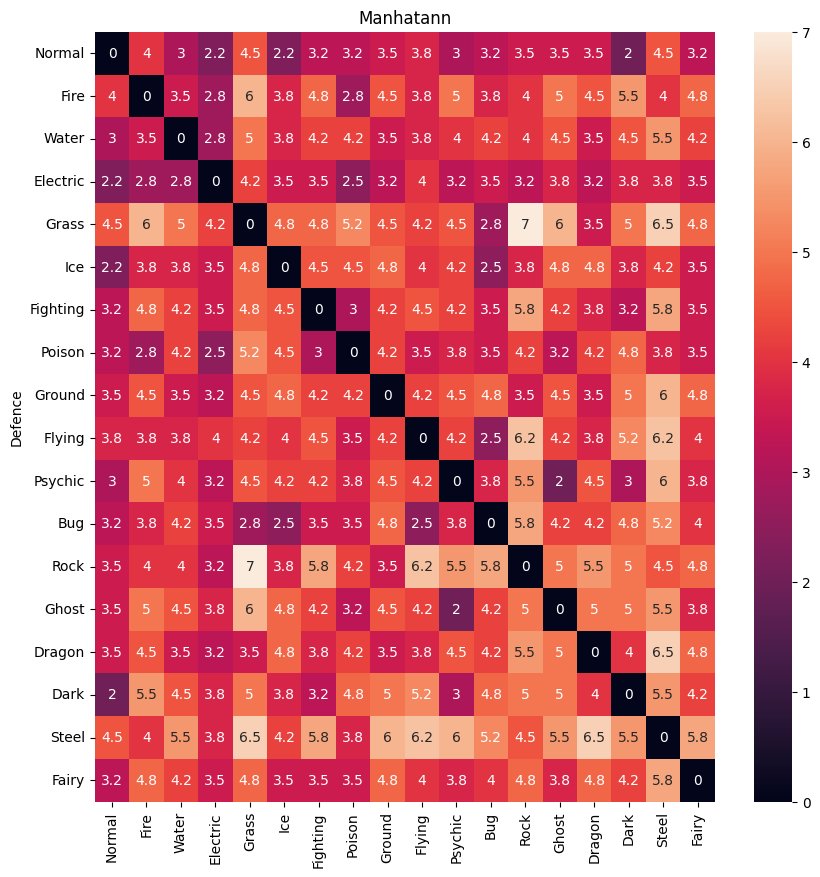

In [25]:
manhattan_def = calculate_and_plot(distance.cityblock, df_def, "Manhatann")

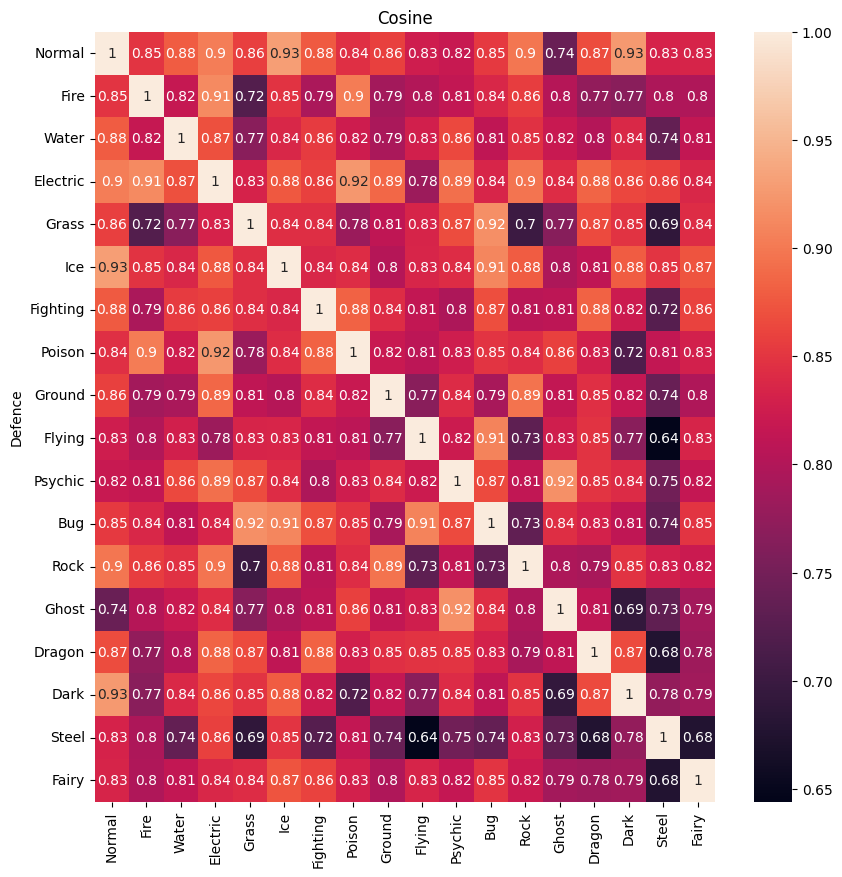

In [26]:
cosine_def = calculate_and_plot(cosine_similarity_wrapper, df_def, "Cosine")

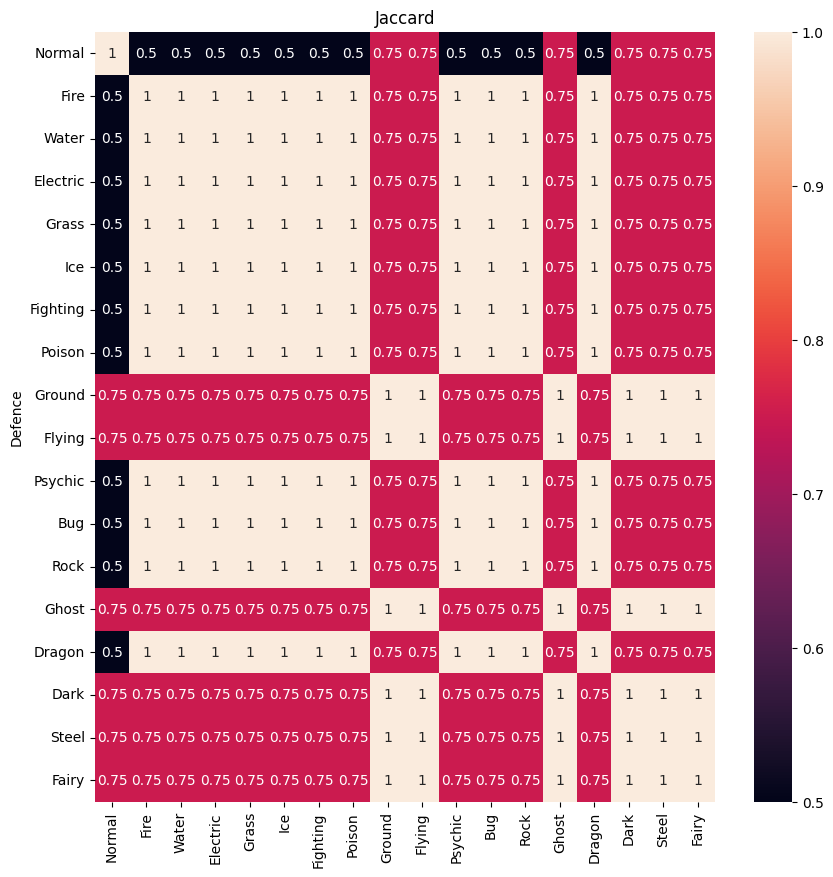

In [27]:
jaccard_def = calculate_and_plot(jaccard_similarity, df_def, "Jaccard")

<ipython-input-21-25026d244d4d>:49: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  replaced = df_pvalues.replace(value_to_int).astype('int64')


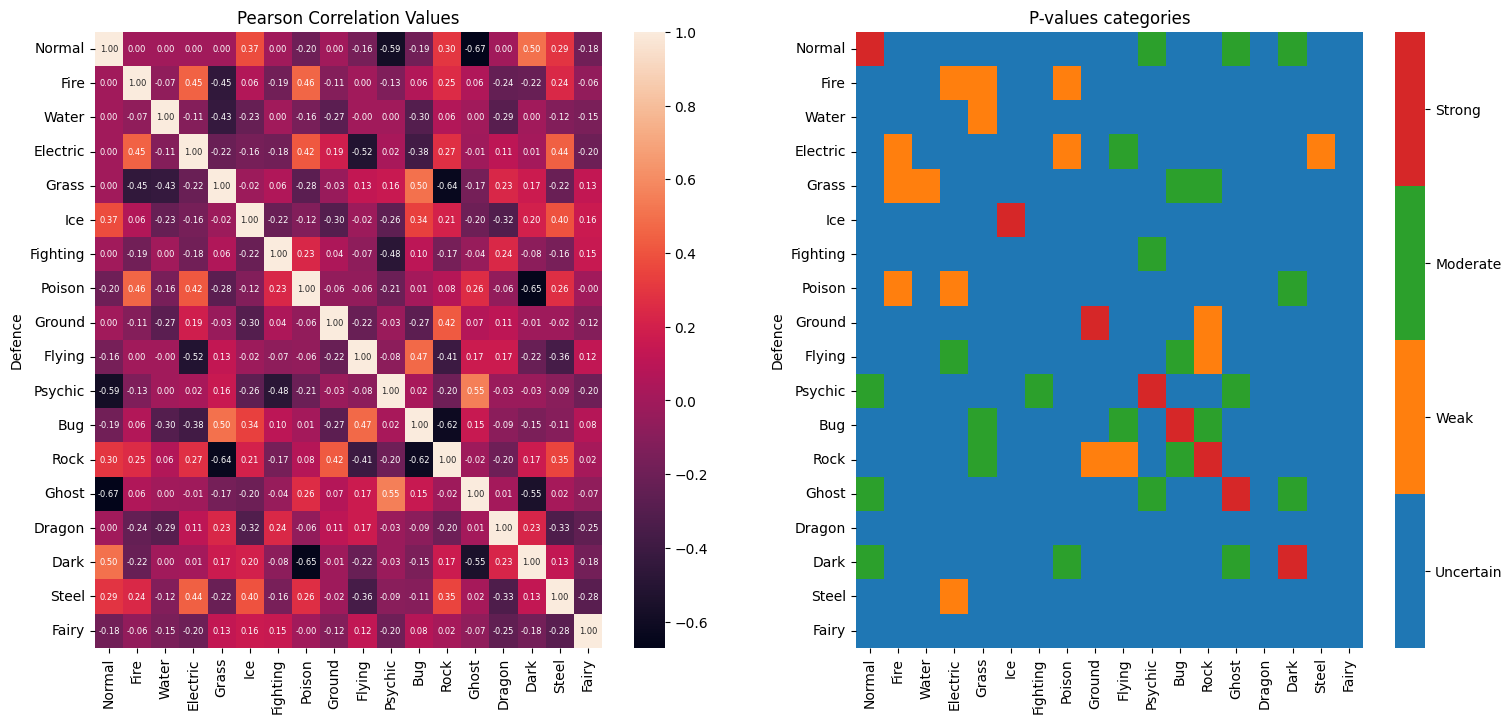

In [28]:
pearson_def = calculate_pearson(df_def, "Pearson")

# Summary Table

To see on which positions in similarity ranking Fire and Flying are.

In [29]:
# creating empty dataframe for storing metrics

type_one = 'Fire'
type_two = 'Flying'

summary_columns = ['Attack', f'Attack Rank for {type_one}', f'Attack Rank for {type_two}',
                   'Defense', f'Defense Rank for {type_one}', f'Defense Rank for {type_two}']

summary_rows = ['Euclidean Distance', 'Manhattan Distance', 'Cosine Similarity', 'Jaccard Similarity', 'Pearson Correlation']

df_summary = pd.DataFrame(0, index=summary_rows, columns=summary_columns)


# Optionally, fill it with NaN (default behavior)
df_summary = df_summary.astype(int)
df_summary[['Attack', 'Defense']] = df_summary[['Attack', 'Defense']].astype(float)

df_summary.head()

,Attack,Attack Rank for Fire,Attack Rank for Flying,Defense,Defense Rank for Fire,Defense Rank for Flying
Euclidean Distance,0.0,0,0,0.0,0,0
Manhattan Distance,0.0,0,0,0.0,0,0
Cosine Similarity,0.0,0,0,0.0,0,0
Jaccard Similarity,0.0,0,0,0.0,0,0
Pearson Correlation,0.0,0,0,0.0,0,0


In [30]:
# filling the dataframe from above

off_dfs = [euclidean_off, manhattan_off, cosine_off, jaccard_off, pearson_off]
def_dfs = [euclidean_def, manhattan_def, cosine_def, jaccard_def, pearson_def]
# summary_rows contains their names

# sorting for every metric
sorting = [True, True, False, False, False]

for o_df, d_df, sort_method, row_name in zip(off_dfs, def_dfs, sorting, summary_rows):
  # setting ranks for type one
  off_rank =  o_df.loc[type_one].sort_values(ascending=sort_method).index.get_loc(type_two)
  def_rank =  d_df.loc[type_one].sort_values(ascending=sort_method).index.get_loc(type_two)
  df_summary.loc[row_name, summary_columns[1]] = off_rank
  df_summary.loc[row_name, summary_columns[4]] = def_rank

  # setting ranks for type two
  off_rank_two =  o_df.loc[type_two].sort_values(ascending=sort_method).index.get_loc(type_one)
  def_rank_two =  d_df.loc[type_two].sort_values(ascending=sort_method).index.get_loc(type_one)
  df_summary.loc[row_name, summary_columns[2]] = off_rank_two
  df_summary.loc[row_name, summary_columns[5]] = def_rank_two

  # setting actual values
  df_summary.loc[row_name, summary_columns[0]] = o_df.loc[type_one, type_two]
  df_summary.loc[row_name, summary_columns[3]] = d_df.loc[type_one, type_two]


In [31]:
df_summary = df_summary.round(decimals=2)
df_summary.head()

,Attack,Attack Rank for Fire,Attack Rank for Flying,Defense,Defense Rank for Fire,Defense Rank for Flying
Euclidean Distance,1.15,1,5,1.52,12,12
Manhattan Distance,2.75,1,2,3.75,5,4
Cosine Similarity,0.90,1,4,0.80,10,12
Jaccard Similarity,1.00,0,1,0.75,11,9
Pearson Correlation,0.38,1,2,0.00,8,6


Just to note: I am using indexing from 0 here, but for most cases 0th position shold be occupied by the type itself. The ranking for other types starts with 1.

## Some notes

I wanted to test/plot something for every method described in the article, but not all of those are fit for every problem.

*   Jaccard similarity is the worst one here, since it limits the values to the set.
*   Since type effectiveness is numerical, but semi-categoric (only values of: 0, 0.5, 1, 2) I've decided it's best to use Manhattan Distance as final metric.
*   Gaps between 0 & 0.5, 0.5 &1  and 1 & 2 are not even, but it illustrates well the proportions of damage dealt/taken in game.
*   As a last step, I will average Manhattan dataframes for offence and defence and see final ranks.

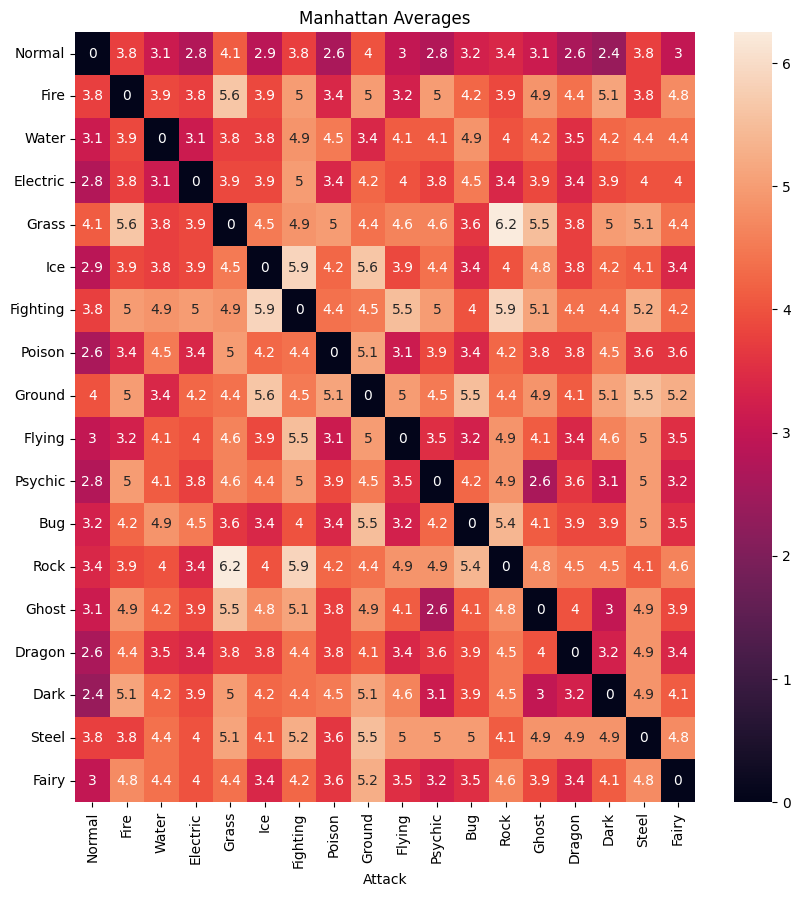

In [32]:
# averages: testing on manhattans

manhattan_avg = (manhattan_off + manhattan_def)/2

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(manhattan_avg, annot=True, ax=ax)
plt.title("Manhattan Averages")
plt.show()

In [33]:
# see the ranking for the manhattan avg - type most similar to fire
manhattan_avg.loc[type_one].sort_values(ascending=True).reset_index()

,Attack,Fire
0,Fire,0.000
1,Flying,3.250
2,Poison,3.375
3,Normal,3.750
4,Electric,3.750
5,Steel,3.750
6,Water,3.875
7,Ice,3.875
8,Rock,3.875
9,Bug,4.250


We can see that:


*   Fire is most similar to Fire - as expected
*   Other than itself, the type most similar to Fire is Flying!
*   As for being worse than Fire - it is weak to both of Bolt/Beam combo and lacks in powerful attacking moves - which Fire has more of.
*   Least similar type is Grass, which makes sense intuitively



In [34]:
# type most similar to flying
manhattan_avg.loc[type_two].sort_values(ascending=True).reset_index()

,Attack,Flying
0,Flying,0.000
1,Normal,3.000
2,Poison,3.125
3,Fire,3.250
4,Bug,3.250
5,Dragon,3.375
6,Psychic,3.500
7,Fairy,3.500
8,Ice,3.875
9,Electric,4.000




*   Aside for itself, type most similiar to Flying is Normal - on one hand it makes sense given they are merged both into Colorless type in TCG, on the other hand - only Normal weakness (Fighting) is a resistance for Flying. They must share most neutral (x1) effectiveness to make up for it.
*   Fire is 3rd on this list, which is still quite high.
*   The 'other' types is both ranking are both Normal and Poison, which means it might be possible to somehow cluster all types into group based on type effectivess alone - this might be a task for another day.



## Ending remarks
Well I was proven wrong.

Here is the [meme](https://www.reddit.com/r/popheadscirclejerk/comments/1imxt9f/pop_girls_as_pok%C3%A9mon_types/) in question (visit at your own risk (of brainrot)).

Below: Fire pokemon and Flying pokemon, more similar than you would think.


In [37]:
%%html
<img src="https://projectpokemon.org/images/sprites-models/swsh-normal-sprites/scorbunny.gif" alt="Scorbunny">
<img src="https://projectpokemon.org/images/sprites-models/swsh-normal-sprites/corvisquire.gif" alt="Corvisquire">

